# Generating Shakespeare word by word

This is a small example of a GPT that is trained on Shakespeare text. This notebook has major inspiration from https://github.com/karpathy/nanoGPT. It's great to get familiar and play around with GPT alwhile not necessarly having a cluster of 1000s of GPUs.

This notebook is conceptually the same as `shakespeare_char.ipynb` but instead of predicting a character, the model will predict a word. We don't use any fancy tokenizer here but use classic regex to split the Shakspeare text into words (you can see that `data/shakespeare_word/prepare.py` changes slightly from `data/shakespeare_char/prepare.py`). The regex could be largely improved since words are case sensitive, etc...

In [ ]:
import os 
import re
import torch
import pickle
import matplotlib.pyplot as plt

from misc import get_batch
from model.gpt2 import GPT2
from trainer.gpt_trainer import GPTTrainer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

We launch the `data/shakespeare_word/prepare.py` file in order to have our data setup.

In [2]:
! python data/shakespeare_word/prepare.py 

length of dataset in characters: 1,115,394
the first 100 unique word tokens are: 3|A|ABHORSON|ABRAHAM|ADRIAN|AEacides|AEdile|AEdiles|AEneas|AEsop|ALL|ALONSO|ANGELO|ANNE|ANOTHER|ANTIGONUS|ANTONIO|ARCHBISHOP|ARCHIDAMUS|ARIEL|AUFIDIUS|AUMERLE|AUTOLYCUS|Abase|Abate|Abated|Abbot|Abel|Abhorred|Abhorson|Abides|Able|About|Above|Abraham|Absolute|Accept|Accomplish|According|Accords|Account|Accountant|Accursed|Accuse|Achieve|Acquaint|Action|Adam|Add|Added|Adding|Address|Adieu|Adjudged|Admit|Adonis|Adoptedly|Adopts|Adrian|Adriatic|Advance|Advantaging|Adversity|Advertising|Advocate|Affection|Affliction|Affrighted|Affrights|Affront|Afore|Afresh|Afric|African|After|Again|Against|Agamemnon|Age|Aged|Agenor|Agreed|Agrippa|Ah|Aim|Aiming|Airy|Ajax|Al|Alack|Alas|Alban|Albeit|Albion|Alcides|Alexander|Alike|Alive|All|Alla
vocab size: 13,321
train has 187,677 tokens
val has 20,853 tokens


In this dataset we have 13,331 unique words (tokens) that form our vocabulary size, 236k tokens for training and 26k for validation.

In [3]:
data_dir = "data/shakespeare_word/"
meta_path = os.path.join(data_dir, 'meta.pkl')
vocab_size = None

if os.path.exists(meta_path):
    with open(meta_path, 'rb') as f:
        meta = pickle.load(f)
    vocab_size = meta['vocab_size']
    itow = meta['itow']
    stow = meta['stow']
    print(f"found vocab_size = {vocab_size} (inside {meta_path})")

found vocab_size = 13321 (inside data/shakespeare_word/meta.pkl)


We then get some meta data and other convienences. For example, the GPT trained hereafter will have the task of predicting the next Shakesperian character given its context. Autoregressively, you can generate many characters that will eventually form words and sentences.

The function `encode` and `decode` will help to convert the produced GPT output into readable characters. We also provide an example of how a `str` is encoded for the model and how the model's output `array` of `int` are decoded to produce Shaspearian litterature.

In [4]:
def encode(s):
    pattern = r'\b\w+\b|[^\w\s]'
    # Find all words
    data = re.findall(pattern, s)
    return torch.tensor([stow[c] for c in data])

decode = lambda l: ' '.join([itow[i] for i in l])

shakpeare_lines = "the king will"
x = encode(shakpeare_lines)
print("The text '{}' is encoded and fed to the GPT as {}".format(shakpeare_lines, x))
y = decode(x.tolist())
assert shakpeare_lines == y

The text 'the king will' is encoded and fed to the GPT as tensor([11963,  7805, 13098])


We choose to use the same hyperparameters from https://github.com/karpathy/nanoGPT for a small example of CPU. 

In [5]:
block_size = 64
n_layer, n_head, n_embd, dropout = 4, 4, 128, 0.0

model = GPT2(vocab_size, block_size, n_embd, n_head, n_layer)
model = model.to(device)
print("GPT number of parameters:", sum(p.numel() for p in model.parameters()))

GPT number of parameters: 4220681


We instantiate also our `GPTTrainer` code in `train.py`. 

In [6]:
trainer = GPTTrainer(model, lr=5e-4, checkpoint_path="metadata/shakespeare_word/")

We call the `train` method from our `trainer` that takes as input : 
- `get_batch`: a function that fetches batches of data
- `max_iters`: number of max iterations
- `batch_size`: batch size 
- `patience`: an argument that essentially spots the training if the validation loss hasn't improve in `#patience` optimization steps. 
- `save_every`: that saves the model weights and other things at `save_every` multiples of iteration step. 

In [7]:
partial_get_batch = lambda split, batch_size: get_batch(data_dir, split, batch_size, device, block_size)
trainer.train(partial_get_batch, max_iters=2000, batch_size=64, patience=2000, save_every=30)

Iter :1999/2000 Train Loss 3.610e+00 / Eval Loss 8.908e+00: 100%|██████████| 2000/2000 [13:11<00:00,  2.53it/s]


Lets see the loss curve from this training and also generate some text ! We also added a `temperature` and `top_k` hyperparameters to give a bit more flexibility to the generation. We see here that the GPT model overfits fast, something that can be amended by using more data and a larger model (our model here is 4M, GPT2 was 124M)

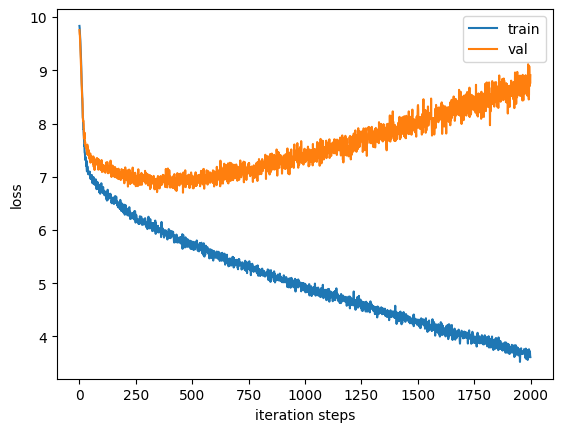

In [8]:
plt.plot(trainer.losses, label='train')
plt.plot(trainer.val_losses, label='val')
plt.xlabel('iteration steps')
plt.ylabel('loss')
plt.legend()

What we see here is that the Tokenizer doesn't keep the structure of Shakespeare, something that is expected.

In [15]:
model.eval()
x = encode("QUEEN MARGARET \n")
x = x.view(1, -1).to(device)
y = model.generate(x, 256, temperature=1.0, top_k=None)
decoded_y = decode(y[0].tolist())
split_decode_y = decoded_y.split(" ")
for i in range(0, len(split_decode_y), 10):
    print(" ".join(split_decode_y[i:i+10]))


100%|██████████| 256/256 [00:00<00:00, 340.48it/s]

QUEEN MARGARET How doth he hated Nurse Now he did
not your grace two eager all came I bethink thee
SLY Madam I will keep with words revive FRIAR LAURENCE
Escalus FRIAR LAURENCE Unhappy a boy none a word in
Verona Go with a lamb LUCIO No more wit they
not that is a woman More that Canst after what
i the friar and men were as certain true As
tis art as I never guilty books re youngest thing
would I would bandy both my body have found me
BOLINGBROKE Good friar He would allow DUKE OF AUMERLE I
would this faster time would prove so I cannot may
burn What says BISHOP OF ELY EXTON When dost bait
it so bold s no impeach God must confess DUCHESS
OF YORK O Lord Thou shalt thou know who dares
liege why I am too descent Farewell why dost thou
not dwell upon us in plain we thou happy I
am a sigh In the forfeit of our person DUKE
OF YORK Hadst thou livest The traitor that I deserved
cousin Hereford thus prove and word the moveables d in
with the king In common executioner Cut them with the
triumph E

# Using multiple GPUs to scale your GPT model

We will used Pytorch's DistributedDataParallel (https://pytorch.org/tutorials/intermediate/ddp_tutorial.html) to train, our GPT model with several GPUs. 

Please note that the model itself will be larger but not that big that using FSDP (https://pytorch.org/tutorials/intermediate/FSDP_tutorial.html) would be overkill here !